Get only review text for sentiment analysis

In [3]:
import pandas as pd
import re
import math

# Read CSV files
data = pd.read_csv("./kinton_reviews.csv")
train = pd.read_csv("./data/train.csv")

In [5]:
# Check the shape of the dataframes
print(data.shape)
print(train.shape)

# Display the first 3 rows of the data dataframe
data.head(3)

(500, 51)
(50, 2)


,query,name,google_id,place_id,location_link,reviews_link,reviews_per_score,reviews,rating,review_id,...,review_questions_Parking options,review_questions_None,review_questions_Vegetarian options,review_questions_Seating type,review_questions_Recommended dishes,review_questions_Parking,review_questions_Kid-friendliness,review_questions_Wait time,review_questions_Wheelchair accessibility,review_questions_Special offers
0,ChIJbVusaw5xhlQRaTWJIYOwgQc,KINTON RAMEN ROBSON,0x5486710e6bac5b6d:0x781b08321893569,ChIJbVusaw5xhlQRaTWJIYOwgQc,https://www.google.com/maps/place/KINTON+RAMEN...,https://search.google.com/local/reviews?placei...,NaN,1803,4.7,Ci9DQUlRQUNvZENodHljRjlvT2xoc1lpMWtiVW95Tmt0bF...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ChIJbVusaw5xhlQRaTWJIYOwgQc,KINTON RAMEN ROBSON,0x5486710e6bac5b6d:0x781b08321893569,ChIJbVusaw5xhlQRaTWJIYOwgQc,https://www.google.com/maps/place/KINTON+RAMEN...,https://search.google.com/local/reviews?placei...,NaN,1803,4.7,Ci9DQUlRQUNvZENodHljRjlvT2pGWlpuSTVRV1Z4UjFodG...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ChIJbVusaw5xhlQRaTWJIYOwgQc,KINTON RAMEN ROBSON,0x5486710e6bac5b6d:0x781b08321893569,ChIJbVusaw5xhlQRaTWJIYOwgQc,https://www.google.com/maps/place/KINTON+RAMEN...,https://search.google.com/local/reviews?placei...,NaN,1803,4.7,Ci9DQUlRQUNvZENodHljRjlvT2xoSk9EQTJWbTVQVkV0UF...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Atract relevant columns and drop rows with missing values
reviews1 = data[["review_rating", "review_text"]].dropna()

# Display the first 5 rows of the reviews1 dataframe
reviews1.head(5)

,review_rating,review_text
1,1,Very disappointing experience. Ordered takeout...
2,4,Kinton Ramen is a great spot in downtown. We o...
5,4,"Food takes a while, but there busy. Delicious ..."
7,5,We have never had a good experience ordering r...
8,3,Unfortunately the chasu pork was thick and rub...


In [9]:
!pip install deep-translator langid textblob

     ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
     ---------- ----------------------------- 0.5/1.9 MB 11.2 MB/s eta 0:00:01
     ---------------- ----------------------- 0.8/1.9 MB 2.5 MB/s eta 0:00:01
     ---------------- ----------------------- 0.8/1.9 MB 2.5 MB/s eta 0:00:01
     ---------------- ----------------------- 0.8/1.9 MB 2.5 MB/s eta 0:00:01
     --------------------- ------------------ 1.0/1.9 MB 849.7 kB/s eta 0:00:02
     --------------------- ------------------ 1.0/1.9 MB 849.7 kB/s eta 0:00:02
     --------------------- ------------------ 1.0/1.9 MB 849.7 kB/s eta 0:00:02
     -------------------------------- ------- 1.6/1.9 MB 794.6 kB/s eta 0:00:01
     -------------------------------------- - 1.8/1.9 MB 866.5 kB/s eta 0:00:01
     ---------------------------------------- 1.9/1.9 MB 816.3 kB/s  0:00:02
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel

Start building sentiment analysis model

In [10]:
from textblob import TextBlob
from deep_translator import GoogleTranslator
import langid

def getPolarity(text):
    text = str(text)
    try:
        lang = langid.classify(text)[0]
    except Exception:
        lang = 'en'
    
    if lang != 'en':
        try:
            text = GoogleTranslator(source='auto', target='en').translate(text=text)
        except Exception:
            pass  # If translation fails, proceed with the original text

    return TextBlob(text).sentiment.polarity

In [11]:
# Sentiment analysis using TextBlob
sample = reviews1.sample(5, random_state=42).copy()
sample["polarity"] = sample["review_text"].apply(getPolarity)
sample

,review_rating,review_text,polarity
75,4,"Alright, I had a veggie miso ramen. It was goo...",0.094562
170,5,Amazing services!,0.750000
212,5,Great service from Stefano! Food was fantastic...,0.270833
77,5,Delicious ramen with friendly staff who checke...,0.410714
412,3,The ramen tasted too authentic for my liking.,0.500000


In [12]:
reviews1["polarity"] = reviews1["review_text"].apply(getPolarity)

# Classify sentiment based on polarity
reviews1["sentiment_model"] = reviews1["polarity"].apply(
    lambda x: 'positive' if x > 0.15 else ('negative' if x < -0.15 else 'neutral')
)

Calculate prediction accuracy

In [13]:
# Classify true sentiment based on review_rating
reviews1["sentiment_true"] = reviews1["review_rating"].apply(
    lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral')
)

# Calculate accuracy
reviews1["accuracy"] = reviews1["sentiment_model"] == reviews1["sentiment_true"]
accuracy = reviews1["accuracy"].mean() * 100

print(f"Prediction Accuracy (All Data): {accuracy:.2f}%")

Prediction Accuracy (All Data): 86.51%


Visualization

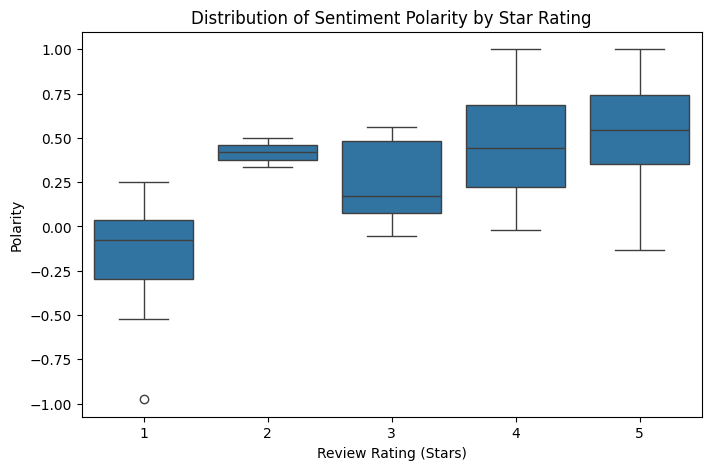

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x="review_rating", y="polarity", data=reviews1)
plt.title("Distribution of Sentiment Polarity by Star Rating")
plt.xlabel("Review Rating (Stars)")
plt.ylabel("Polarity")
plt.show()